# Problem set 4, Spring 2022: Starter/hints

In [1]:
# General helpers
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Cross-validation helpers
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

np.random.seed(42)

# Data generator

In [2]:
def genMortality(n,type=0):
    # Generate COVID-19 deaths for different ages and comorbidity groups
    # Baseline mortality rate
    benchProb = 0.0005
    # These are multiplyers from the base probability of death
    # Note:  These numbers are real, and come from the US CDC
    multiplyers = np.array([0.1,1./16.,1.,4.,10.,30.,90.,220.,630.])
    # Age group means corresponding to the multipliers
    ageMean     = np.array([2.,10.,25.,35.,45.,57.,70.,80.,95.])
    # Probability of death for different age groups
    ageGroupProbs = benchProb*multiplyers
    # generate data
    ageGroup = np.random.randint(low=0,high=9,size=n)
    # This is totally made up by me
    # These are the number of other medical conditions you might have
    # Known as comorbities (assume 0 to 3)
    comorb   = np.random.randint(low=0,high=4,size=n)
    # Function to multiple death probs by for comorb
    # totally made up by me
    # Note:  We will change this line eventually
    if(type==0):
        comorbm  = 1.0*(comorb==0)+2.0*(comorb==1)+3.0*(comorb==2)+4.0*(comorb==3)
    if(type==1):
        comorbm  = 1.0*(comorb==0)+3.0*(comorb==1)+0.25*(comorb==2)+5.0*(comorb==3)
    if(type>1):
        return
    # Xp is prob of death
    Xp = comorbm*ageGroupProbs[ageGroup]
    Xp = np.minimum(Xp,1.)
    # Age vector
    Xvec = ageMean[ageGroup]+np.random.uniform(low=-2.,high=2.,size=n)
    # Target is 0 alive, 1 dead
    y = (np.random.uniform(low=0.,high=1.,size=n)<Xp)
    # Set predictors to age, and comorbidity
    X = np.zeros( (n,2))
    X[:,0] = Xvec
    X[:,1] = comorb
    # also return the ageGroup for ease of use
    return X,y,ageGroup

In [3]:
# Generate data
# Extra lines enable reducing the data to certain (older) age groups
Xraw,yraw, ageGroup = genMortality(100000,type=0)
X = Xraw.copy()
y = yraw.copy()
# These might be useful to have around
ageMean     = np.array([2.,10.,25.,35.,45.,57.,70.,80.,95.])
benchProb = 0.0005
multiplyers = np.array([0.1,1./16.,1.,4.,10.,30.,90.,220.,630.])
# Factor of 2,5 comes from type 0 comorbidity adjustment
#  mean(1,2,3,4)
pTrue = 2.5*benchProb*multiplyers

Text(0, 0.5, 'Prob(death)')

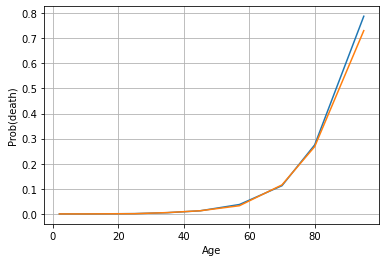

In [4]:
# Plot means for different age groups, both theoretical, and simulation
# A good check of the monte-carlo sim
prDeath = np.zeros(9)
for i in range(9):
    prDeath[i] = np.mean(y[ageGroup==i])   
plt.plot(ageMean,pTrue)
plt.plot(ageMean,prDeath)
plt.grid()
plt.xlabel("Age")
plt.ylabel("Prob(death)")

# Basic logistic model

The model looks pretty good, but the last line shows that random guessing (0) would get you about 88 percent accuracy since this is a very unbalanced data set.  (That is a good thing since this is measuring deaths.)

In [5]:
# Run logistic model, and print out mean(y), 
#   and 1-mean(y)
# Do randomized cross valiation and print results
lr = LogisticRegression(penalty="none",solver="lbfgs")
nmc = 25
testSize = 0.5
shuffle = ShuffleSplit(n_splits=nmc, test_size=testSize)
CVInfo = cross_validate(lr, X, y, cv=shuffle,return_train_score=True)
print(np.mean(CVInfo['train_score']))
print(np.std(CVInfo['train_score']))
print(np.mean(CVInfo['test_score']))
print(np.std(CVInfo['test_score']))
# Look at the fraction of deaths and 1-this fraction
# What do these values tell you about the accuracy of a naive prediction?
print(np.mean(y))
print(1.-np.mean(y))
#since logistic regression results the probability of y=1, dose mean(y) of 0.12 mean we predict that 12% of the 
#people died?

0.9274512000000001
0.0009041783894785452
0.9272736
0.0006943594458203871
0.12982
0.87018


Text(0, 0.5, 'Prob(death)')

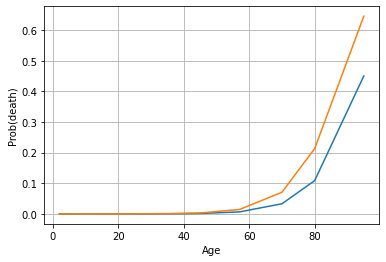

In [8]:
# This gives an example of how to do some of the plots
#    from the problem set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
lr = LogisticRegression(penalty="none",solver="lbfgs")
lr.fit(X_train,y_train)
# set up plotting array with set of age means for x-axis
ageMean     = np.array([2.,10.,25.,35.,45.,57.,70.,80.,95.])
# Build a matrix of features for the graph
Xplt = np.zeros((len(ageMean),2))
Xplt[:,0] = ageMean
# Column 2 will get comorbidities 

# Sweep across comorbidity
for i in [0,1]:
    # Load in the correct comorbidity value
    Xplt[:,1] = i*np.ones(len(ageMean))
    # Predict probability of (y=1) for (age,comorbidity) pairs
    pp = lr.predict_proba(Xplt)
    # plot probility across ages
    plt.plot(ageMean,pp[:,1],label=i)
plt.grid()
plt.xlabel('Age')
plt.ylabel('Prob(death)')

# You should be able to do this for all 4 comorbidity levels
# Also, set up a nice legend too


In [10]:
print(Xplt)
print(Xplt[:,0])

[[ 2.  1.]
 [10.  1.]
 [25.  1.]
 [35.  1.]
 [45.  1.]
 [57.  1.]
 [70.  1.]
 [80.  1.]
 [95.  1.]]
[ 2. 10. 25. 35. 45. 57. 70. 80. 95.]


1.) The initial run of a logistic regression prints out some results for baseline data. 
What do the standard deviations tell you about the quality of your monte-carlo estimates of training and testing 
accuracy? Also, are these numbers impressive given the overall mean for y = 0?

The basic model indicate that the train data has accuracy of approximate 0.927 and standard deviation of 0.0009,
and test data has accuracy of approximate 0.927 with standard deviation of 0.0006, which implies we have generate a 
very good result and accuray with the model. The low standard indicate this naive model has generated a result with decent accuracy and low variation. However, this naive model dose not tell the best story and may contain bias given the imbalanced dataset since random guessing (0) would get me about 87 percent accuracy given the imbalanced feature of our data.

2.) Generate a single 50/50 train/test split.  Estimate the same model on the training data.  For the test data set report:  a) the confusion matrix, b) precision, c) recall.  To do this you will need a predictor for y_test.  This is easy to get once you have done a lr.fit(X_train).  (Assume lr is your logistic regression object.)  After this you can get y_test_pred = lr.predict(X_test) to get predictors for your test data.  With this and y_test you should be ready to go to use the scikit-learn confusion matrix function.  

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
lr = LogisticRegression(penalty="none",solver="lbfgs")
lr.fit(X_train,y_train)
y_pred = lr.predict (X_test)


print("precision:",precision_score(y_test, y_pred))

print("recall:",recall_score(y_test, y_pred))

print("f1:",f1_score(y_test, y_pred))

precision: 0.7535785468381954
recall: 0.6429123512134797
f1: 0.6938605271938605


3) Split your data into a single test/train split.  Now use the predict_proba() method to predict the probability of death for the different ages, and the comorbidities.  Generate a nice plot showing the probabilities plotted across ages (x-axis) and probabilities (y-axis), using a different line for each comorbidity.  I have put some extensive hints into the starter code for how to get started with this.  It shows how to plot one of these lines (comorbidity = 0 and 1).  From this is should be easy to do this for all of [0,1,2,3], and set up a nice legend and labels on the plot.  See the starter file for more info!

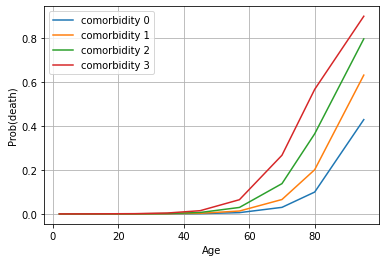

In [27]:
#single test/train split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
lr = LogisticRegression(penalty="none",solver="lbfgs")
lr.fit(X_train,y_train)
ageMean     = np.array([2.,10.,25.,35.,45.,57.,70.,80.,95.])
# Build a matrix of features for the graph
Xplt = np.zeros((len(ageMean),2))
Xplt[:,0] = ageMean
fig, ax = plt.subplots()
for i in [0,1,2,3]:
    Xplt[:,1]= i*np.ones(len(ageMean))
    pp=lr.predict_proba(Xplt)
    plt.plot(ageMean,pp[:,1],label=i)
plt.grid()
plt.xlabel('Age')
plt.ylabel('Prob(death)')
ax.legend(['comorbidity 0', 'comorbidity 1', 'comorbidity 2', 'comorbidity 3'])

4) Now try a KNN classifier for classification.  Repeat the monte-carlo cross validation from the starter, and commented on in part (1) above, but you should now try 4 different values for the neighbors, 10, 25, 50, 100.  Report the mean test accuracy for each, and use this to decide on your best model.  How does the logistic compare with the best nearest neighbor model?  (25 monte-carlo runs, and test_sample = 0.5 for each of the 4 different neighbor values.)

In [36]:
from sklearn.neighbors import KNeighborsClassifier
def knn(X,y):
    for i in [10,25,50,100]:
        knn = KNeighborsClassifier(n_neighbors=i)
        nmc = 25
        testSize = 0.5
        shuffle = ShuffleSplit(n_splits=nmc, test_size=testSize)
        CVInfo = cross_validate(knn, X, y, cv=shuffle,return_train_score=True)
        print("Number of Neighbors:", i)
        print("Mean Test Accuracy:", np.mean(CVInfo['test_score']))

knn(X,y) 

Number of Neighbors: 10
Mean Test Accuracy: 0.9423504
Number of Neighbors: 25
Mean Test Accuracy: 0.943848
Number of Neighbors: 50
Mean Test Accuracy: 0.9443136
Number of Neighbors: 100
Mean Test Accuracy: 0.9444104


5) Now change the structure of the data generator.  

Xraw,yraw, ageGroup = genMortality(100000, type=1)

X = Xraw.copy()

y = yraw.copy()

There is some kind of medical miracle here which means you are better off with 2 comorb for some strange reason. Rerun the logistic regression in the randomized cross validation as before, and report the mean test accuracy. 

In [42]:
Xraw,yraw, ageGroup = genMortality(100000, type=1)

X = Xraw.copy()

y = yraw.copy()
lr = LogisticRegression(penalty="none",solver="lbfgs")
nmc = 25
testSize = 0.5
shuffle = ShuffleSplit(n_splits=nmc, test_size=testSize)
CVInfo = cross_validate(lr, X, y, cv=shuffle,return_train_score=True)
print(np.mean(CVInfo['test_score']))

0.9114296000000001


6) Repeat the plot you did before with the probabilities, from part (3).  Is there anything a little strange about the plot?

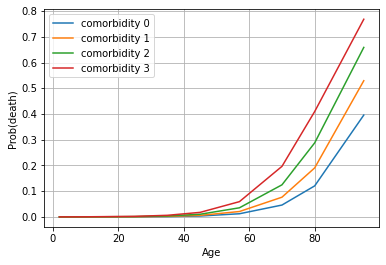

In [35]:
Xraw,yraw, ageGroup = genMortality(100000, type=1)

X = Xraw.copy()

y = yraw.copy()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
lr = LogisticRegression(penalty="none",solver="lbfgs")
lr.fit(X_train,y_train)
ageMean     = np.array([2.,10.,25.,35.,45.,57.,70.,80.,95.])
# Build a matrix of features for the graph
Xplt = np.zeros((len(ageMean),2))
Xplt[:,0] = ageMean
fig, ax = plt.subplots()
for i in [0,1,2,3]:
    Xplt[:,1]= i*np.ones(len(ageMean))
    pp=lr.predict_proba(Xplt)
    plt.plot(ageMean,pp[:,1],label=i)
plt.grid()
plt.xlabel('Age')
plt.ylabel('Prob(death)')
ax.legend(['comorbidity 0', 'comorbidity 1', 'comorbidity 2', 'comorbidity 3'])

For all the comorbidity from 0 to 3, the proability of death is decreased after the age of 40 compared with the case of using type=0

7) Now repeat your work with the KNN classifier from part (4) on this new data set.  Report the best model, and the mean test accuracy for this model.  How is it doing now in relation to the logistic model?

In [43]:
Xraw,yraw, ageGroup = genMortality(100000,type=1)
X = Xraw.copy()
y = yraw.copy()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
# Set up a classifier
for i in [10,25,50,100]:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    print(i)
   
    print(knn.score(X_test, y_test))
 

10
0.94304
25
0.94436
50
0.94474
100
0.94552


The best model is the one with 100 neighbors. The test accuracy for the logistic model is 0.911 which is samller than the accuracy score of 0.94552 for Knn model. Thus, knn model is doing a better job than logistic model in this case.

8) Repeat the probability plot for the KNN classifier. Do the lines make more sense than in (6)?

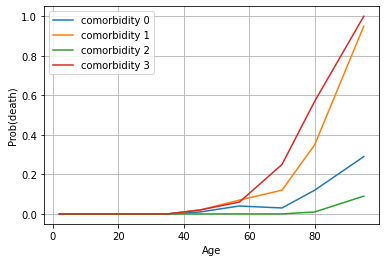

In [44]:
Xraw,yraw, ageGroup = genMortality(100000, type=1)

X = Xraw.copy()

y = yraw.copy()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
knn = KNeighborsClassifier(n_neighbors=i)
knn.fit(X_train,y_train)
ageMean     = np.array([2.,10.,25.,35.,45.,57.,70.,80.,95.])
# Build a matrix of features for the graph
Xplt = np.zeros((len(ageMean),2))
Xplt[:,0] = ageMean
fig, ax = plt.subplots()
for i in [0,1,2,3]:
    Xplt[:,1]= i*np.ones(len(ageMean))
    pp=knn.predict_proba(Xplt)
    plt.plot(ageMean,pp[:,1],label=i)
plt.grid()
plt.xlabel('Age')
plt.ylabel('Prob(death)')
ax.legend(['comorbidity 0', 'comorbidity 1', 'comorbidity 2', 'comorbidity 3'])

The line makes more sense than the plot in the logistic regression case. Now,people with 3 comorbidities have much higher probaility of death than people with less than 3 comorbidities and the gap is even large when compared the age group older than 80, which is more close to the real-world case as older people with comorbidities are more susceptible to COVID.

9) Take this data set you've been using since part (5), and limit this to ages that are in the index range (ageGroup) 8 and above.  Report the mean(y) and 1-mean(y).  Run randomized cross validations for the logistic regression, and the knn (optimal neighbors from 7).  Report means scores on train and test samples.  Do the models look different?  How do they compare with the full sample of ages?  Can you give some idea what might be going on?  Here is some Python code for how to set this up:  (note:  I used copy to make sure I was creating a new clean memory space, just to be careful)

In [45]:
Xraw,yraw, ageGroup = genMortality(100000, type=1)

print(Xraw.shape)

X = Xraw[ageGroup>=8,:].copy()

y = yraw[ageGroup>=8].copy()
# Report the mean(y) and 1-mean(y)
print('mean(y)',np.mean(y))
print('1-mean(y)',1.-np.mean(y))
print()


(100000, 2)
mean(y) 0.5890686408920573
1-mean(y) 0.41093135910794265



In [50]:
#logistic
lr = LogisticRegression(penalty="none",solver="lbfgs")
shuffle = ShuffleSplit(n_splits=25, test_size=0.5)
CVInfo = cross_validate(lr, X, y, cv=shuffle,return_train_score=True)
    # record train accuracy
print(np.mean(CVInfo['train_score']))
    # record test accuracy
print(np.mean(CVInfo['test_score']))


0.6726581352833638
0.6720087735331749


In [53]:
#knn
lr = KNeighborsClassifier(n_neighbors=100)
shuffle = ShuffleSplit(n_splits=25, test_size=0.5)
CVInfo = cross_validate(lr, X, y, cv=shuffle,return_train_score=True)
print('knn_train',np.mean(CVInfo['train_score']))
print('knn_test',np.mean(CVInfo['test_score']))

knn_train 0.8865374771480803
knn_test 0.8871577408152075


The mean(y) for full sample is 0.12982 and 1-mean(y)is 0.87018.
The mean(y) for sample of ages that are in the index range (ageGroup) 8 and above is  0.589 and 1-mean(y)is 0.4109. 
In both the cases of train accuracy and test accuracy, knn model score higher than logistic model.
The test score of knn model with full sample size is 0.94552 and the test score of logistic model with full sample size is 0.9114, which are all higher than the test score generated with sample of ages that are in the index range (ageGroup) 8 and above.
One resean that knn model transends the logistic model is that knn model support non-linear solution where logistic model support only linear solution. Thus, such limitation of the logistic model makes the logistic model to not fit the real world data as better as the knn model dose given the imbanlanced feature of some data.